# Inspect images for poorly predicted MTT samples

In [1]:
import polars as pl
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

In [2]:
preds = pl.read_parquet("../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/predictions_continuous.parquet")
meta = pl.read_parquet("../1_snakemake/inputs/metadata/metadata.parquet").drop(["Metadata_Compound", "Metadata_Log10Conc"])
preds = preds.join(meta, on=["Metadata_Plate", "Metadata_Well"])

In [3]:
preds = preds.with_columns(
    pl.when(pl.col("Metadata_Compound") == "DMSO").then(pl.lit("DMSO")).otherwise(pl.lit("Compound")).alias("Well_type")
)

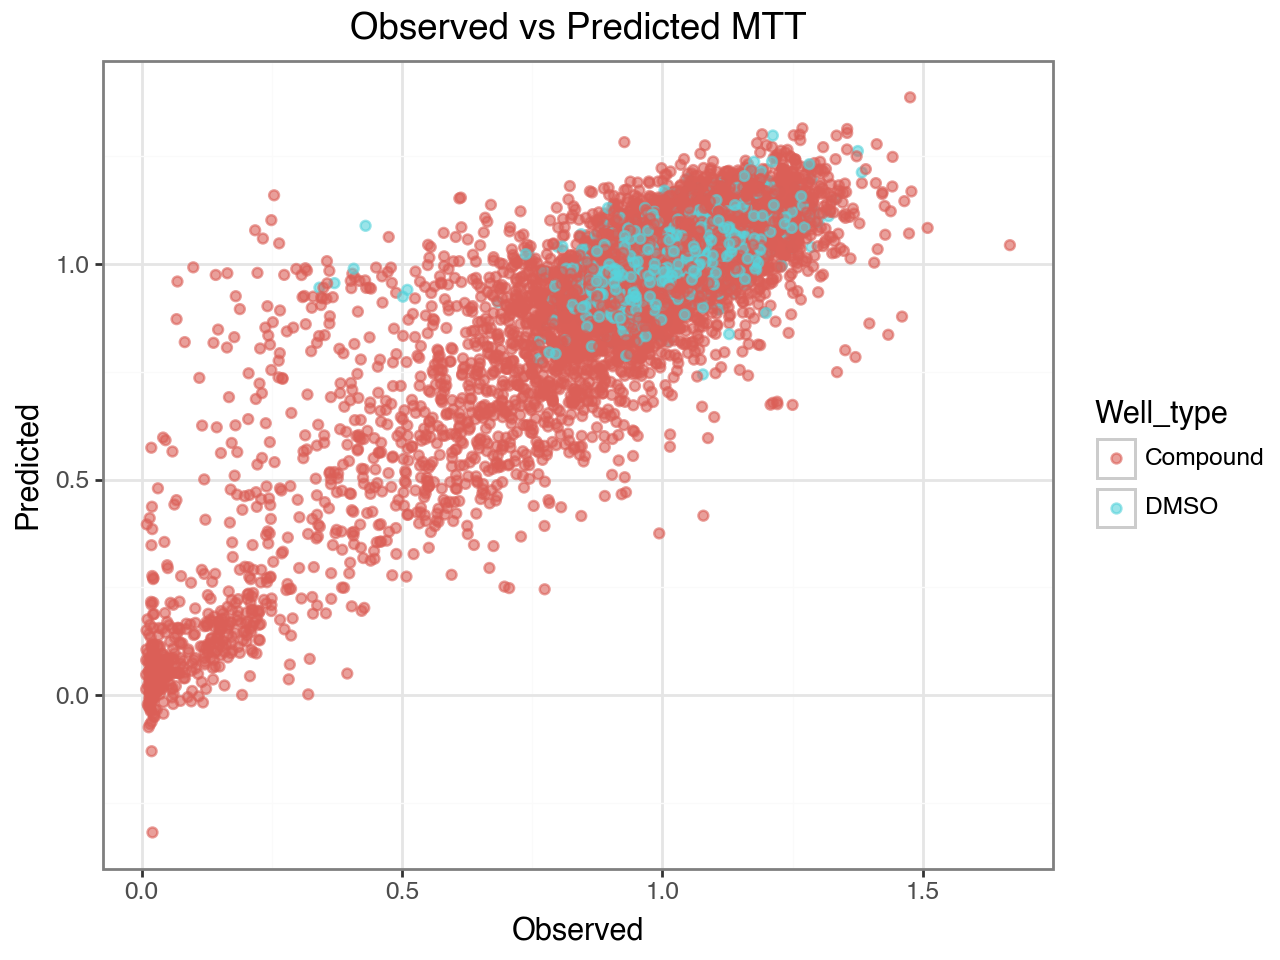

In [4]:
from plotnine import aes, geom_point, ggplot, labs, theme_bw, geom_histogram
import plotnine as pn

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized"), aes(x="Observed", y="Predicted", color="Well_type"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)

plot1.show()

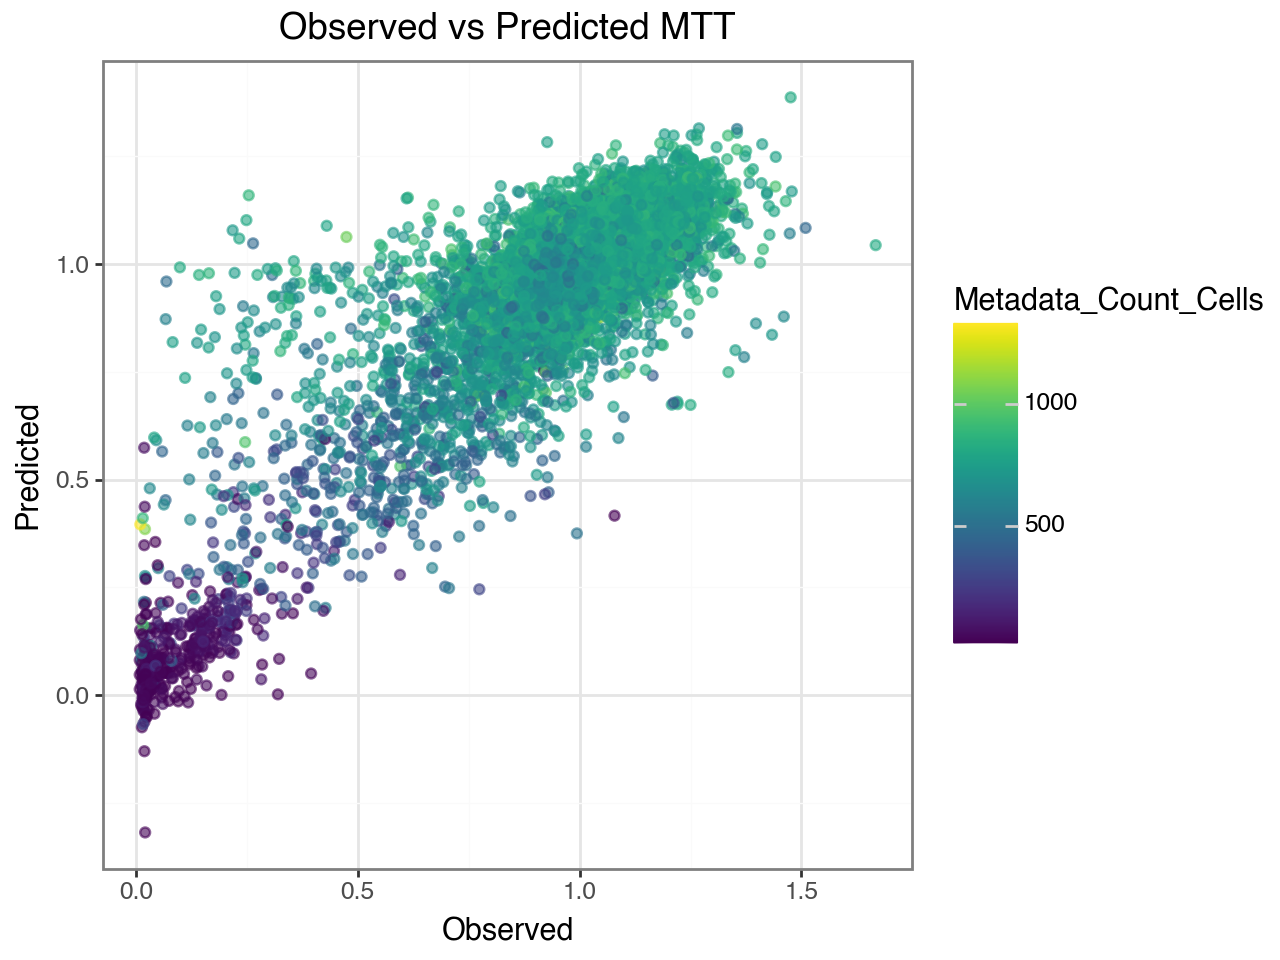

In [5]:
plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized"), aes(x="Observed", y="Predicted", color="Metadata_Count_Cells"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)

plot1.show()

In [6]:
# Get residuals of the 1:1 line
mtt = preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized")

mtt = mtt.with_columns(
    (pl.col("Predicted") - pl.col("Observed")).alias("Diff_pred_obs")
)

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 240'. Pick better value with 'binwidth'.


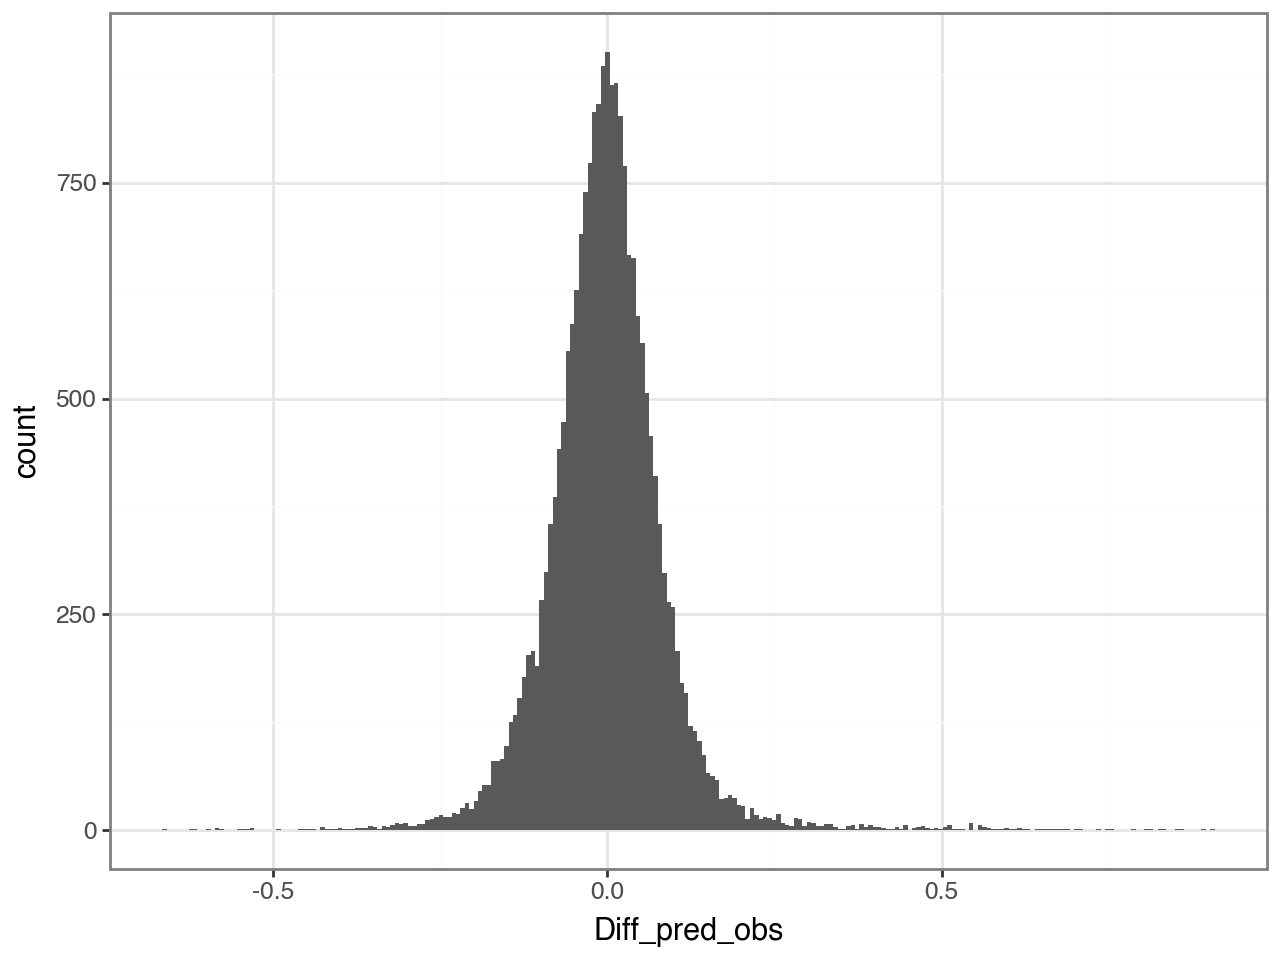

In [7]:
plot1 = (
    ggplot(mtt, aes(x="Diff_pred_obs"))
    + geom_histogram()
    + labs(
        x="Diff_pred_obs",
    )
    + theme_bw()
)

plot1.show()

In [8]:
print(mtt.shape)
print(mtt.filter(pl.col("Diff_pred_obs") > 0).shape)
print(mtt.filter(pl.col("Diff_pred_obs") < 0).shape)

std = mtt.select(pl.col("Diff_pred_obs").std()).to_numpy()[0][0]

thresh = std*2.58 # 2.58 std = p-val 0.01

mtt = mtt.with_columns(
    pl.when(pl.col("Diff_pred_obs") > thresh)
      .then(pl.lit("Higher"))
      .when(pl.col("Diff_pred_obs") < (-1*thresh))
      .then(pl.lit("Lower"))
      .otherwise(pl.lit("Normal")).alias("Outlier_flag"),
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID"),
)

(21815, 29)
(10549, 29)
(11266, 29)


In [9]:
mtt.select(pl.col("Outlier_flag").value_counts()).unnest("Outlier_flag")

Outlier_flag,counts
str,u32
"""Lower""",189
"""Normal""",21331
"""Higher""",295


In [11]:
# Get target set library
targets = pl.read_parquet("../1_snakemake/inputs/annotations/cg_motive.parquet")
targets = targets.select(["target", "interaction_type", "OASIS_ID"]).unique().with_columns(
    pl.concat_str(["target", "interaction_type"], separator="_").alias("target_set")
)

target_set_size = targets.select(pl.col("target_set").value_counts()).unnest("target_set").filter(pl.col("counts") >= 3)
keep_sets = target_set_size.select("target_set").to_series().to_list()
targets = targets.filter(pl.col("target_set").is_in(keep_sets))

In [12]:

cmpd_meta = meta.select(["Metadata_OASIS_ID", "Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"]).with_columns(
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID")
).drop(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"]).rename({"Metadata_OASIS_ID": "OASIS_ID"})

targets = targets.join(cmpd_meta, on="OASIS_ID").select(["target_set", "Unique_ID"]).unique()

In [12]:
import polars as pl
from scipy.stats import hypergeom

def overrepresentation_analysis(target_set_library: pl.DataFrame, target_hits: list, universe: list):
    target_hits_set = set(target_hits)
    universe_set = set(universe)
    sets = target_set_library.select(pl.col("target_set")).unique().to_series()
    results = []

    # For each target set, calculate the overlap and perform the hypergeometric test
    for target_set in tqdm(sets):
        targets_in_set = set(target_set_library.filter(pl.col("target_set") == target_set)["Unique_ID"].to_list())
        
        overlap = target_hits_set.intersection(targets_in_set)
        overlap_size = len(overlap)

        M = len(universe_set)  # Total number of genes in the universe
        n = len(targets_in_set)  # Number of genes in the gene set
        N = len(target_hits_set)  # Number of gene hits
        x = overlap_size  # Number of overlapping genes (successes)

        p_value = hypergeom.sf(x - 1, M, n, N)

        results.append({
            "target_set": target_set,
            "overlap_size": overlap_size,
            "target_set_size": n,
            "hit_list_size": N,
            "universe_size": M,
            "p_value": p_value,
        })

    return pl.DataFrame(results)


In [13]:
higher_hits = mtt.filter(pl.col("Outlier_flag") == "Higher").select("Unique_ID").to_series().to_list()
lower_hits = mtt.filter(pl.col("Outlier_flag") == "Lower").select("Unique_ID").to_series().to_list()

universe = mtt.select("Unique_ID").to_series().unique().to_list()

In [18]:
# Count the number of annotated compounds for each outlier
targets_per_cmpd = targets.select(pl.col("Unique_ID").value_counts()).unnest("Unique_ID").filter(pl.col("Unique_ID").is_in(higher_hits))
ann_cmpds = targets_per_cmpd.select("Unique_ID").to_series().unique().to_list()

unann_cmpds = [i for i in higher_hits if i not in ann_cmpds]
unann_cmpds = [i for i in unann_cmpds if "Compound_" not in i]
unann_cmpds = [i for i in unann_cmpds if "DMSO" not in i]
unann_cmpds

['Isavuconazonium (sulfate)_0.0456431545317173_L24_plate_41002702',
 'Oritavancin (diphosphate)_100.0_J23_plate_41002878',
 'Ibufenac_0.4107883870601654_F01_plate_41002887',
 'Ozanimod (hydrochloride)_33.5_O21_plate_41002890',
 'Chlorothalonil_33.5_B24_plate_41002892',
 'Bedaquiline (fumarate)_100.0_F05_plate_41002896',
 'N1-Isopropyl-N4-phenylbenzene-1,4-diamine_100.0_N10_plate_41002896',
 'Methyl carbamate_1.0_C24_plate_41002907',
 '1,1-Dioxothiolan_3.5_F01_plate_41002886',
 'Brilliant blue G-250_33.5_D02_plate_41002893',
 'Bronopol_1.0_P21_plate_41002907',
 'Chlorothalonil_100.0_E09_plate_41002692',
 'Pralsetinib_33.5_O14_plate_41002890',
 'Quinoxyfen_33.5_N15_plate_41002956',
 'Lubiprostone_3.5_M22_plate_41002688',
 'Oritavancin (diphosphate)_100.0_K01_plate_41002692',
 'Sampatrilat_33.5_F08_plate_41002890',
 'N1-Isopropyl-N4-phenylbenzene-1,4-diamine_1.0_F10_plate_41002907',
 'Quinoxyfen_100.0_G10_plate_41002947',
 'Quinoxyfen_100.0_P23_plate_41002878',
 'Brilliant blue G-250_100.

In [ ]:

# Perform overrepresentation analysis
higher_results = overrepresentation_analysis(targets, higher_hits, universe)
lower_results = overrepresentation_analysis(targets, lower_hits, universe)

In [14]:
# FDR adjust the p-values
def fdr_polars(df: pl.DataFrame):
    p_values = df.select("p_value").to_series().to_numpy()
    _, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    df = df.with_columns(pl.Series("fdr", p_adjusted))
    return df

In [15]:
higher_results = fdr_polars(higher_results)
lower_results = fdr_polars(lower_results)

Interesting! The "higher" results, where we predicted higher MTT results than were actually observed, are enriched for compounds that target drug metabolizing enzymes. The MTT assay adds some labelled substrate to the cells, and then measures how much of it is metabolized via fluorescence. This finding makes a lot of sense - the cells look like they are undergoing high rates of metabolism (which they are) it's just that the metabolic system is busy metabolizing the drugs and therefore doesn't have as much space capacity to metabolize the added substrate.

In [16]:
higher_results = higher_results.select(["target_set", "fdr", "overlap_size", "target_set_size"]).sort("fdr")

## Interactive plots

In [7]:
import plotly.express as px

filtered_preds = preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized").to_pandas()

fig = px.scatter(
    filtered_preds,
    x="Observed",
    y="Predicted",
    title="Observed vs Predicted MTT",
    labels={"Observed": "Observed", "Predicted": "Predicted"},
    hover_data=["Metadata_Plate", "Metadata_Well"]
)

fig.show()